In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.optimize import curve_fit
from scipy.stats import norm, gamma
from scipy import signal

import statsmodels.api as sm
import statsmodels.tsa as tsa


import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

# Spectral analysis to find peaks
# then filter to isolate the peaks

In [2]:
# load data
fpath = '' # same as current folder
file = 'Raymo_2005Int.mat'
mat_file = sio.loadmat(fpath + file)
del mat_file['__header__']
del mat_file['__version__']
del mat_file['__globals__']
print(mat_file.keys())
mat_file

dict_keys(['nt', 'o18i'])


{'nt': array([[   0,    1,    2, ..., 5318, 5319, 5320]], dtype=uint16),
 'o18i': array([[3.23 , 3.23 , 3.18 , ..., 2.882, 2.896, 2.91 ]])}

In [3]:
# create variables for
x_unadj = mat_file['nt'].squeeze() 
y_unadj = mat_file['o18i'].squeeze()

x = x_unadj.copy()
y = y_unadj.copy()
#x += -x.mean() # remove mean (i think i need to do this?)
#y += -y.mean()

N = len(x)
#ndpery = 365.25
#nyears = len(x)/ndpery
t = np.arange(0,N) # time values of 0 to ndays

Text(0.5, 1.0, 'y time series (unadjusted)')

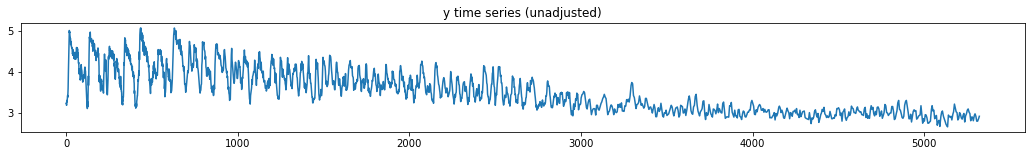

In [4]:
plt.subplots(figsize=(18,2))
plt.plot(y_unadj)
plt.title('y time series (unadjusted)')

Text(0.5, 1.0, 'y time series (detrended)')

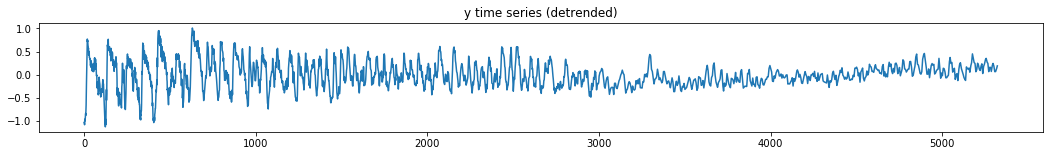

In [5]:
plt.subplots(figsize=(18,2))
y = signal.detrend(y)
plt.plot(y)
plt.title('y time series (detrended)')

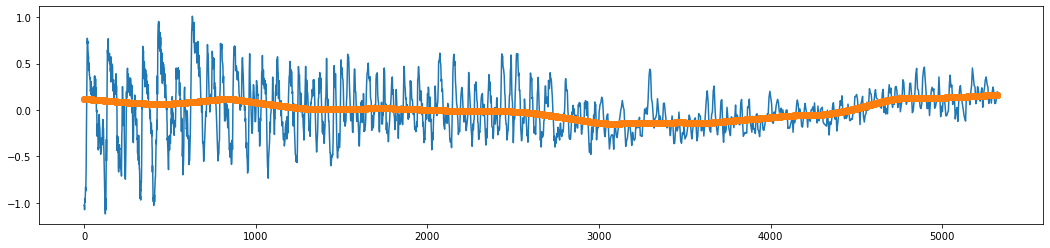

In [6]:
# attempt at lowess regression to assess annual cycle # just for fun
lowess = sm.nonparametric.lowess
z = lowess(y,t,frac=1/8,return_sorted=False)

fig, ax = plt.subplots(figsize=(18,4))
plt.plot(y)
plt.plot(z,marker='o')

## Using WOSA

In [7]:
fs = 1 # sampling frequency, determines nyquist max freq by fs/2
window = 'hann'
M = 2**9 # always use power of two #this is chunklength M
noverlap = M // 2
df = N/(M/2)*1.2-1 # Nobs / nspectralestimates=M/2; could multiple by 1-1.5 or 1.2 for hann window

freq, Psd = signal.welch(y, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

print(df)

23.9421875


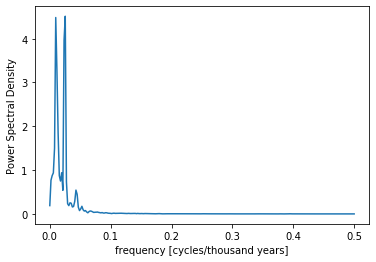

In [8]:
plt.plot(freq, Psd)
plt.xlabel('frequency [cycles/thousand years]')
plt.ylabel('Power Spectral Density')
plt.show()

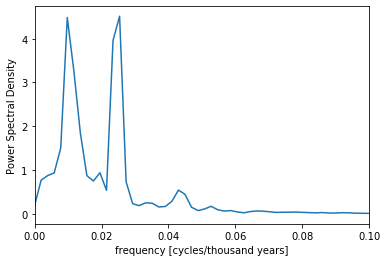

In [9]:
# reduce range but dont change nyquist freq
plt.plot(freq, Psd)
plt.xlabel('frequency [cycles/thousand years]')
plt.ylabel('Power Spectral Density')
plt.xlim(0,.1)
plt.show()

In [10]:
1/freq[1:] # kyr per cycle

array([512.        , 256.        , 170.66666667, 128.        ,
       102.4       ,  85.33333333,  73.14285714,  64.        ,
        56.88888889,  51.2       ,  46.54545455,  42.66666667,
        39.38461538,  36.57142857,  34.13333333,  32.        ,
        30.11764706,  28.44444444,  26.94736842,  25.6       ,
        24.38095238,  23.27272727,  22.26086957,  21.33333333,
        20.48      ,  19.69230769,  18.96296296,  18.28571429,
        17.65517241,  17.06666667,  16.51612903,  16.        ,
        15.51515152,  15.05882353,  14.62857143,  14.22222222,
        13.83783784,  13.47368421,  13.12820513,  12.8       ,
        12.48780488,  12.19047619,  11.90697674,  11.63636364,
        11.37777778,  11.13043478,  10.89361702,  10.66666667,
        10.44897959,  10.24      ,  10.03921569,   9.84615385,
         9.66037736,   9.48148148,   9.30909091,   9.14285714,
         8.98245614,   8.82758621,   8.6779661 ,   8.53333333,
         8.39344262,   8.25806452,   8.12698413,   8.  

(array([-250, -249, -248, -247, -246, -245, -244, -243, -242, -241, -240,
        -239, -238, -237, -236, -235, -234, -233, -232, -231, -230, -229,
        -228, -227, -226, -225, -224, -223, -222, -221, -220, -219, -218,
        -217, -216, -215, -214, -213, -212, -211, -210, -209, -208, -207,
        -206, -205, -204, -203, -202, -201, -200, -199, -198, -197, -196,
        -195, -194, -193, -192, -191, -190, -189, -188, -187, -186, -185,
        -184, -183, -182, -181, -180, -179, -178, -177, -176, -175, -174,
        -173, -172, -171, -170, -169, -168, -167, -166, -165, -164, -163,
        -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152,
        -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141,
        -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130,
        -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119,
        -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108,
        -107, -106, -105, -104, -103, 

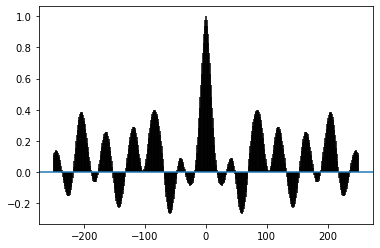

In [11]:
# plot autocorrelations for each
plt.acorr(y,usevlines=True,maxlags=250)

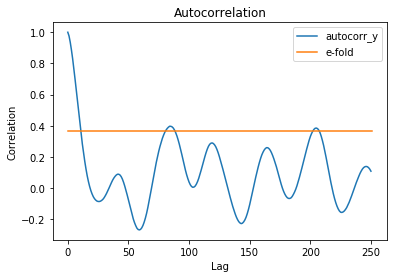

In [12]:
areg_y,conf_y = tsa.stattools.acf(y,nlags=250,alpha=0.05, fft=True)

# hartmann barnes p121
# estimate autocorr for red noise by avg of one lag and sqrt of two lag
auto_y = (areg_y[1]+np.sqrt(areg_y[2]))/2
plt.plot(areg_y, label='autocorr_y')
plt.plot(np.linspace(0,len(areg_y),len(areg_y)),np.ones(len(areg_y))/np.exp(1), label='e-fold')
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

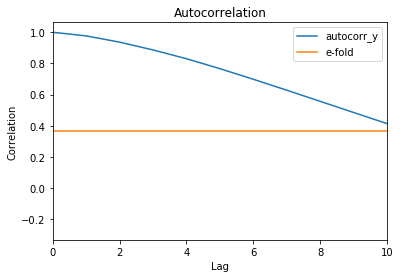

In [13]:
plt.plot(areg_y, label='autocorr_y')
plt.plot(np.linspace(0,len(areg_y),len(areg_y)),np.ones(len(areg_y))/np.exp(1), label='e-fold')
plt.xlim(0,10)
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

In [162]:
print(auto_y, areg_y[1])

0.9722415054324574 0.976676414444795


In [153]:
# keep simple per Dennis
autocorr_df = N/2 - 1

print(N, autocorr_df)

5321 2659.5 257


(0, 0.1)

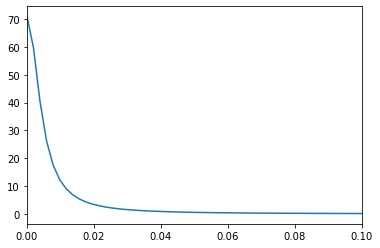

In [16]:
freq_dummy = np.linspace(0,np.pi,len(freq)) # dummy inputs that are same length as freq
red_y = (1-auto_y**2)/(1-2*auto_y*np.cos(freq_dummy*1)+auto_y**2)
plt.plot(freq,red_y)
#plt.ylim(0,6)
plt.xlim(0,.1)

In [17]:
# this ratio works because i used same number of data points for red_x and freq
# this shows up above in choice of freq_dummy
redadj_y = np.sum(Psd)/np.sum(red_y)*red_y

In [155]:
np.sum(Psd)/np.sum(red_y)

0.10579721340489538

[]

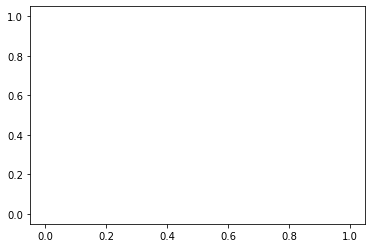

In [18]:
plt.plot()

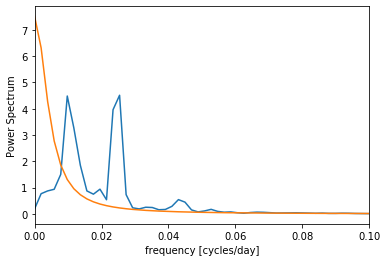

In [158]:
plt.plot(freq, Psd)
plt.plot(freq, redadj_y)
#plt.ylim([0.5e-3, 1])
plt.xlim(0, .1)
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum')
plt.show()

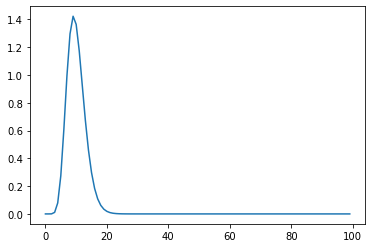

In [20]:
# check f distribution
#autocorr_df = ndays//2-1
plt.plot(stats.f.pdf(np.arange(0,10,.1),df,autocorr_df))

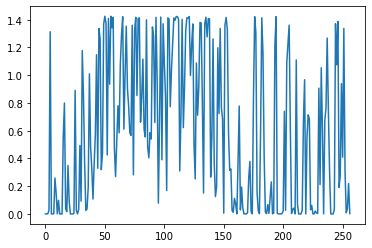

In [21]:
# check f stats for y and x
plt.plot(stats.f.pdf(Psd/redadj_y,df,autocorr_df))

In [22]:
# find red noise line with 99% confidence interval with a priori reason to believe each orbital peak
clevel = 0.99
conf = stats.f.ppf(clevel,df,autocorr_df) # f stat 
chanceoccurence = clevel**(M/2/1.2) # true a posteriori confidence level
print(conf, clevel, chanceoccurence)

1.7989855525208578 0.99 0.11717676776534698


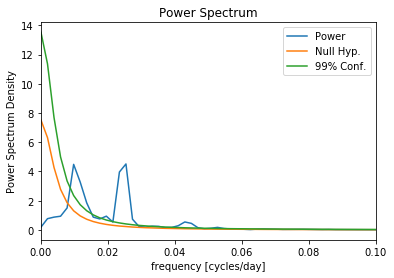

In [23]:
# plot with confidence interval
plt.plot(freq, Psd, label='Power')
plt.plot(freq, redadj_y, label='Null Hyp.')
plt.plot(freq,redadj_y*conf, label='99% Conf.')
plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Power Spectrum')
plt.legend()
plt.show()

(0, 0.1)

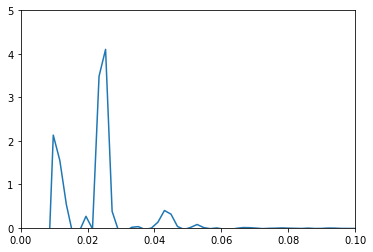

In [24]:
# y significant peaks
plt.plot(freq,Psd-redadj_y*conf)
plt.ylim(0,5)
plt.xlim(0,.1)

In [25]:
print(np.where(Psd==Psd.max()))
print(np.where(Psd-redadj_y*conf>.3))

(array([13]),)
(array([ 5,  6,  7, 12, 13, 14, 22, 23]),)


In [26]:
# local maxima
select_freq = np.array([freq[5],freq[13],freq[22]])
periods = np.array([1/freq[5], 1/freq[13], 1/freq[22]])
print(freq[5], freq[13], freq[22])
print(1/freq[5], 1/freq[13], 1/freq[22]) # yrs / cycle
print(periods)

0.009765625 0.025390625 0.04296875
102.4 39.38461538461539 23.272727272727273
[102.4         39.38461538  23.27272727]


## Split data to make sure significant

5321 2660 2661


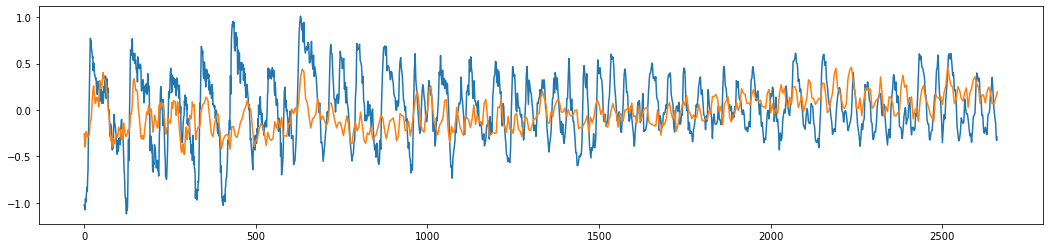

In [27]:
y_a = y.copy()[0:len(y)//2]
y_b = y.copy()[len(y)//2:]
print(len(y),len(y_a),len(y_b))

fig, ax = plt.subplots(figsize=(18,4))
plt.plot(y_a)
plt.plot(y_b)

In [28]:
## WOSA
N_a = len(y_a)
N_b = len(y_b)

df_a = N_a/(M/2)*1.2-1 # Nobs / nspectralestimates=M/2; could multiple by 1-1.5 or 1.2 for hann window
df_b = N_b/(M/2)*1.2-1 # Nobs / nspectralestimates=M/2; could multiple by 1-1.5 or 1.2 for hann window

freq_ab, Psd_a = signal.welch(y_a, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

freq_ab, Psd_b = signal.welch(y_b, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')

print(df, df_a, df_b)

23.9421875 11.46875 11.4734375


5321 1329.0 1329.5
2.230419412305311 2.230118504981355


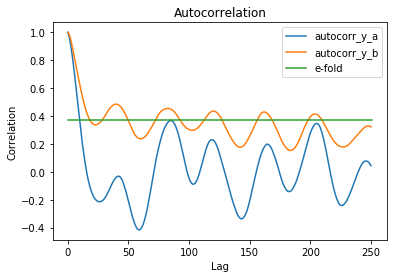

In [29]:
## Autocorrelation
autocorr_df_a = N_a/2 - 1
autocorr_df_b = N_b/2 - 1

areg_y_a,conf_y_a = tsa.stattools.acf(y_a,nlags=250,alpha=0.05, fft=True)
areg_y_b,conf_y_b = tsa.stattools.acf(y_b,nlags=250,alpha=0.05, fft=True)

# estimate autocorr for red noise by avg of one lag and sqrt of two lag # hartmann barnes p121
auto_y_a = (areg_y_a[1]+np.sqrt(areg_y_a[2]))/2
auto_y_b = (areg_y_b[1]+np.sqrt(areg_y_b[2]))/2

freq_ab_dummy = np.linspace(0,np.pi,len(freq_ab)) # dummy inputs that are same length as freq
red_y_a = (1-auto_y_a**2)/(1-2*auto_y_a*np.cos(freq_ab_dummy*1)+auto_y_a**2)
red_y_b = (1-auto_y_b**2)/(1-2*auto_y_b*np.cos(freq_ab_dummy*1)+auto_y_b**2)
redadj_y_a = np.sum(Psd_a)/np.sum(red_y_a)*red_y_a
redadj_y_b = np.sum(Psd_b)/np.sum(red_y_b)*red_y_b

print(N, autocorr_df_a, autocorr_df_b)

# find red noise line with 99% confidence interval
conf_a = stats.f.ppf(0.99,df_a,autocorr_df_a) # f stat 
conf_b = stats.f.ppf(0.99,df_b,autocorr_df_b) # f stat 
print(conf_a, conf_b)


plt.plot(areg_y_a, label='autocorr_y_a')
plt.plot(areg_y_b, label='autocorr_y_b')
plt.plot(np.linspace(0,len(areg_y_a),len(areg_y_a)),np.ones(len(areg_y_a))/np.exp(1), label='e-fold')
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

In [30]:
print(auto_y_a,auto_y_b)

0.9680377512737224 0.9849664794878001


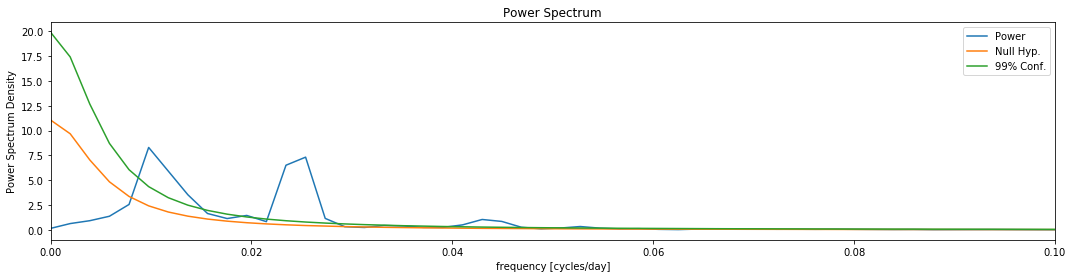

In [31]:
# plot with confidence interval # 2
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(freq_ab, Psd_a, label='Power')
plt.plot(freq_ab, redadj_y_a, label='Null Hyp.')
plt.plot(freq_ab,redadj_y_a*conf, label='99% Conf.')
plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Power Spectrum')
plt.legend()
plt.show()

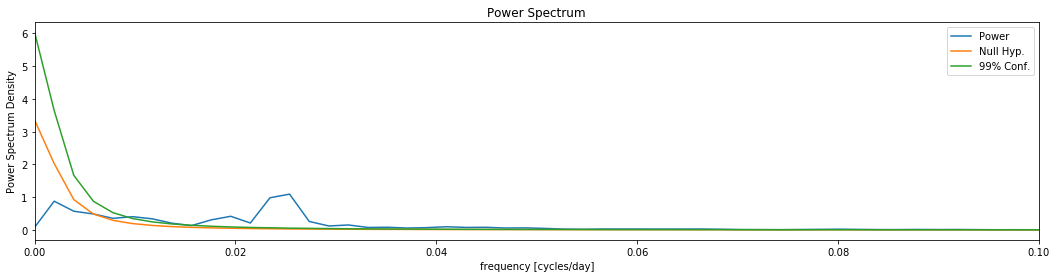

In [32]:
# plot with confidence interval # 2
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(freq_ab, Psd_b, label='Power')
plt.plot(freq_ab, redadj_y_b, label='Null Hyp.')
plt.plot(freq_ab,redadj_y_b*conf, label='99% Conf.')
plt.xlim([0, .1])
plt.xlabel('frequency [cycles/day]')
plt.ylabel('Power Spectrum Density')
plt.title('Power Spectrum')
plt.legend()
plt.show()

# Filtering

In [33]:
print(select_freq)
print(periods)
nyq = 1/(2*1) # nyquist 1/(2*timestep)
wn = select_freq/nyq
print(wn)

[0.00976562 0.02539062 0.04296875]
[102.4         39.38461538  23.27272727]
[0.01953125 0.05078125 0.0859375 ]


In [34]:
# high pass filter on 40k cycle
b, a = signal.butter(4, wn[1], btype='high')
w, h = signal.freqs(b,a)
out = signal.filtfilt(b,a,y)

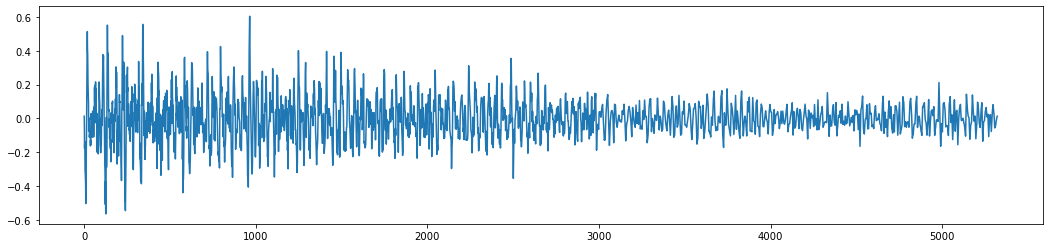

In [35]:
# high pass filter looks too noisy
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out)
#plt.plot(np.cos(2*np.pi/periods[1]*x))

(0, 0.1)

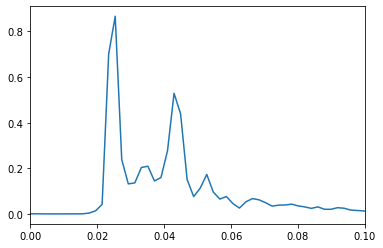

In [36]:
freq_check, Psd_o = signal.welch(out, fs=fs, window=window,
                               nperseg=M, noverlap=noverlap,
                               scaling='density')
plt.plot(freq_check,Psd_o)
plt.xlim(0,.1)

In [137]:
# get bandwidth
bw = freq[1] - freq[0]
bw

print(select_freq[1],wn[1])

0.025390625 0.05078125


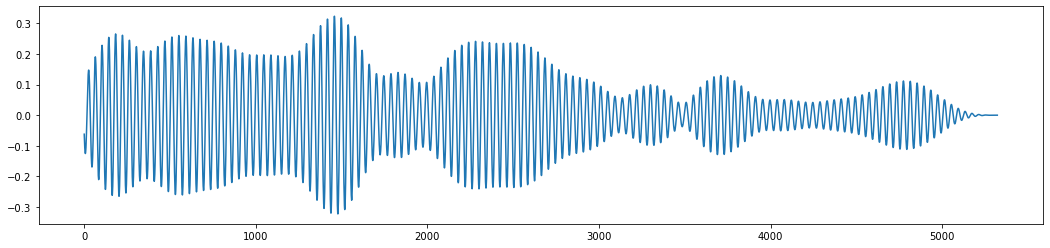

In [154]:
# try band pass and high pass on 40k year
b, a = signal.butter(5, [wn[1]-bw/nyq, wn[1]+bw/nyq], btype='band')
# b, a = signal.butter(5, [select_freq[1]-bw/nyq, select_freq[1]+bw/nyq], btype='band')
# b, a = signal.butter(5, wn[1], btype='high')
w40, h40 = signal.freqz(b,a) # response of digital filter
out40 = signal.filtfilt(b,a,y)

fig, ax = plt.subplots(figsize=(18,4))
# plt.plot(y)
plt.plot(out40,marker='')
#plt.xlim(500,5000)
#plt.plot(np.cos(2*np.pi/periods[1]*x))

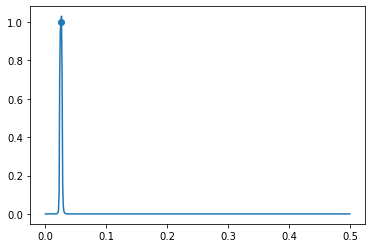

In [121]:
plt.plot(w40/np.pi/2,np.abs(h40))
plt.scatter(select_freq[1],1)

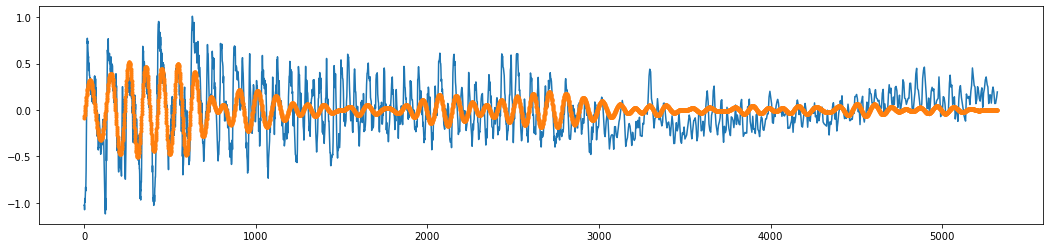

In [144]:
# try band pass on 100k year
b, a = signal.butter(4, [wn[0]-bw/nyq, wn[0]+bw/nyq], btype='band')
# b, a = signal.butter(4, wn[0], btype='low')
w100, h100 = signal.freqz(b,a)
out100 = signal.filtfilt(b,a,y)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(y)
plt.plot(out100,marker='.')
#plt.xlim(500,5000)
#plt.plot(np.cos(2*np.pi/periods[1]*x))

In [145]:
# recent correlation
np.corrcoef(y[0:500],out100[0:500])

array([[1.        , 0.70038815],
       [0.70038815, 1.        ]])

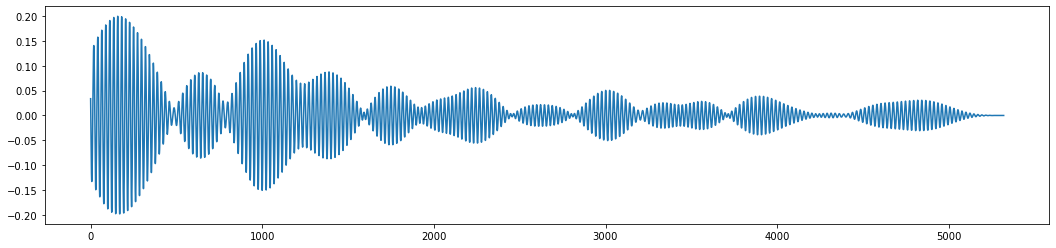

In [146]:
# try band pass on 23k year
b, a = signal.butter(5, [wn[2]-bw/nyq, wn[2]+bw/nyq], btype='band')
# b, a = signal.butter(5, wn[2], btype='high')
w23, h23 = signal.freqz(b,a)
out23 = signal.filtfilt(b,a,y)
fig, ax = plt.subplots(figsize=(18,4))
plt.plot(out23)
#plt.xlim(500,5000)
#plt.plot(np.cos(2*np.pi/periods[1]*x))

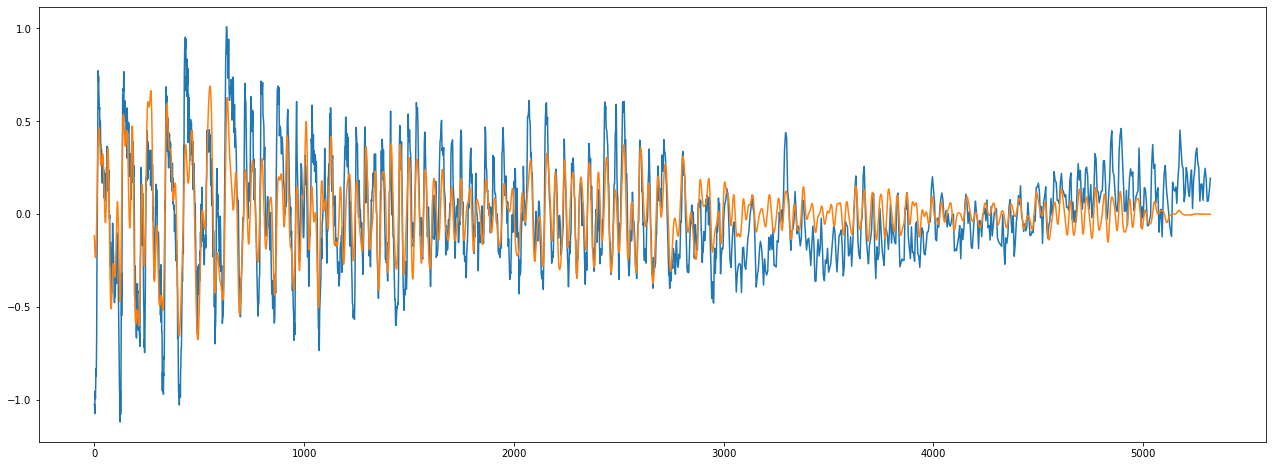

In [147]:
fig, ax = plt.subplots(figsize=(22,8))
plt.plot(y)
plt.plot(out40+out100+out23,marker='')

## Response Function

(0, 0.1)

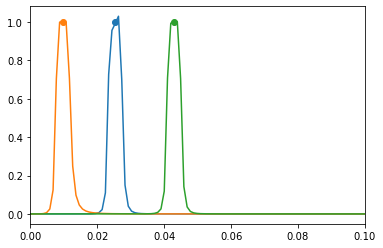

In [149]:
plt.plot(w40/np.pi/2,np.abs(h40))
plt.plot(w100/np.pi/2,np.abs(h100))
plt.plot(w23/np.pi/2,np.abs(h23))

plt.scatter(select_freq[1],1)
plt.scatter(select_freq[0],1)
plt.scatter(select_freq[2],1)

plt.xlim(0,0.1)

(0, 0.5)

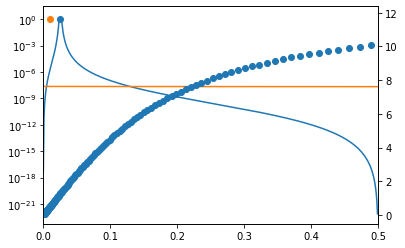

In [133]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.semilogy(w40/np.pi/2,np.abs(h40))
plt.semilogy(w100/np.pi/2,np.abs(h100))
# plt.plot(w23/np.pi/2,np.abs(h23))

plt.scatter(select_freq[1],1)
plt.scatter(select_freq[0],1)
# plt.scatter(select_freq[2],1)

ax2 = ax1.twinx()
angle100 = np.unwrap(np.angle(h100))
plt.scatter(w100/np.pi/2,angle100)

plt.xlim(0,0.1)

## Impulse Response

In [86]:
impulse_dummy = np.array([1])
impulse_dummy = np.append(impulse_dummy, np.zeros(N-1))
len(impulse_dummy)

5321

(0, 2000)

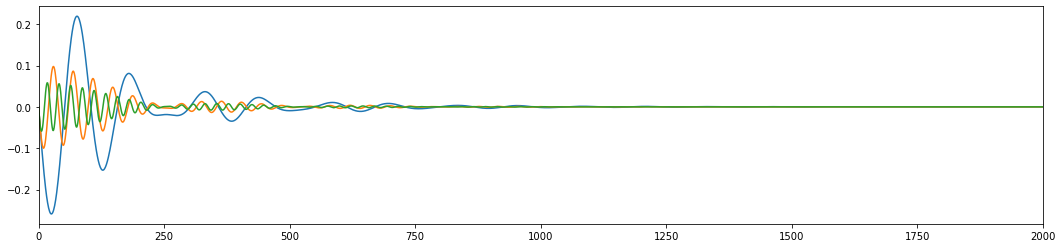

In [89]:
fig, ax = plt.subplots(figsize=(18,4))

for w in wn:
    b, a = signal.butter(4, [w-bw/nyq, w+bw/nyq], btype='band')
    w, h = signal.freqs(b,a)
    impout = signal.filtfilt(b,a,impulse_dummy)

    plt.plot(impout)

plt.xlim(0,2000)

## Tutorial

In [ ]:
b, a = signal.butter(2, 0.5, btype='low', analog=True)
w, h = signal.freqs(b,a)
plt.plot(w,20*np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / year]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()